# Predicting Flight Delays with a Random Forest

1. Read airline data into Pandas dataframe, clean up, and compute basic statistics
2. Plot normalized feature distributions for delay and no-delay subsamples
3. Compute intrinsic discrepancies
4. Convert categorical variables into binary ones
5. Recompute intrinsic discrepancies
6. Split data set into training and testing parts, with option to adjust the prevalence in either part
7. Do a quick fit of the random forest classifier to make sure things are working
8. Do grid search to optimize hyper-parameter settings of random forest
9. Compute confusion matrix of optimal random forest and make some plots
10. Investigate variability of the precision, recall, and queue rate versus threshold curves.


In [1]:
'''
Read in the airline data, store them in a Pandas dataframe, 
do some cleanup, and compute basic statistics.
'''
import pandas as pd
import numpy as np

# Function to check the input data and make some conversions
def convertStrings(row):
    row[1] = int(row[1][2:])
    row[2] = int(row[2][2:])
    row[3] = int(row[3][2:])
    
    assert row[0]>=2004 and row[0]<=2007, "Invalid year %i" %row[0]
    assert row[1]>=1 and row[1]<=12,      "Invalid month %i" %row[1]
    if row[1] in [1,3,5,7,8,10,12]:
        assert row[2]>=1 and row[2]<=31,  "Invalid day of month %i for month %i" %(row[2],row[1])
    elif row[1] in [4,6,9,11]:
        assert row[2]>=1 and row[2]<=30,  "Invalid day of month %i for month %i" %(row[2],row[1])
    else:
        assert row[2]>=1 and row[2]<=29,  "Invalid day of month %i for month %i" %(row[2],row[1])
    assert row[3]>=1 and row[3]<=7,       "Invalid day of week %i" %row[3]
    assert row[4]>=0 and row[4]<=2600,    "Invalid hour %i" %row[4]
    if row[4]>=2400:
        hour   = row[4] - 2400
        print('Out of range hour %i mapped to %i' %(row[4],hour))
        row[4] = hour
    assert row[8]>0,                      "Invalid distance %i" %row[8]
    assert row[9]=="Y" or row[9]=="N",    "Invalid delay flag %s" %row[9]
    
    row[9] = row[9]=="Y"
    
    return row


df0         = pd.read_table("AirlineData/data-0.1m.csv", sep=',', header=0)
df1         = df0.apply(convertStrings, axis=1, broadcast=False, raw=True, reduce=None)
df1_delay   = df1[df1.dep_delayed_15min==True]
df1_nodelay = df1[df1.dep_delayed_15min==False]

delays          = len(df1_delay)
nodelays        = len(df1_nodelay)
airlines        = sorted(df1.UniqueCarrier.unique())
origins         = sorted(df1.Origin.unique(), reverse=True)
destinations    = sorted(df1.Dest.unique(), reverse=True)
numAirlines     = len(airlines)
numOrigins      = len(origins)
numDestinations = len(destinations)
minDist         = df1.Distance.min()
maxDist         = df1.Distance.max()
print(' ')
print('Number of delays =       %i' %delays)
print('Number of no-delays =    %i' %nodelays)
print('Number of airlines =     %i' %numAirlines)
print('Number of origins =      %i' %numOrigins)
print('Number of destinations = %i' %numDestinations)
print('Minimum distance =       %f' %minDist)
print('Maximum distance =       %f' %maxDist)

Out of range hour 2400 mapped to 0
Out of range hour 2430 mapped to 30
Out of range hour 2437 mapped to 37
Out of range hour 2400 mapped to 0
Out of range hour 2455 mapped to 55
Out of range hour 2400 mapped to 0
Out of range hour 2400 mapped to 0
Out of range hour 2444 mapped to 44
Out of range hour 2400 mapped to 0
Out of range hour 2400 mapped to 0
Out of range hour 2400 mapped to 0
Out of range hour 2405 mapped to 5
Out of range hour 2437 mapped to 37
Out of range hour 2428 mapped to 28
Out of range hour 2400 mapped to 0
Out of range hour 2426 mapped to 26
Out of range hour 2528 mapped to 128
Out of range hour 2400 mapped to 0
Out of range hour 2400 mapped to 0
Out of range hour 2540 mapped to 140
Out of range hour 2400 mapped to 0
Out of range hour 2448 mapped to 48
Out of range hour 2450 mapped to 50
 
Number of delays =       19274
Number of no-delays =    80726
Number of airlines =     23
Number of origins =      307
Number of destinations = 306
Minimum distance =       27.0000

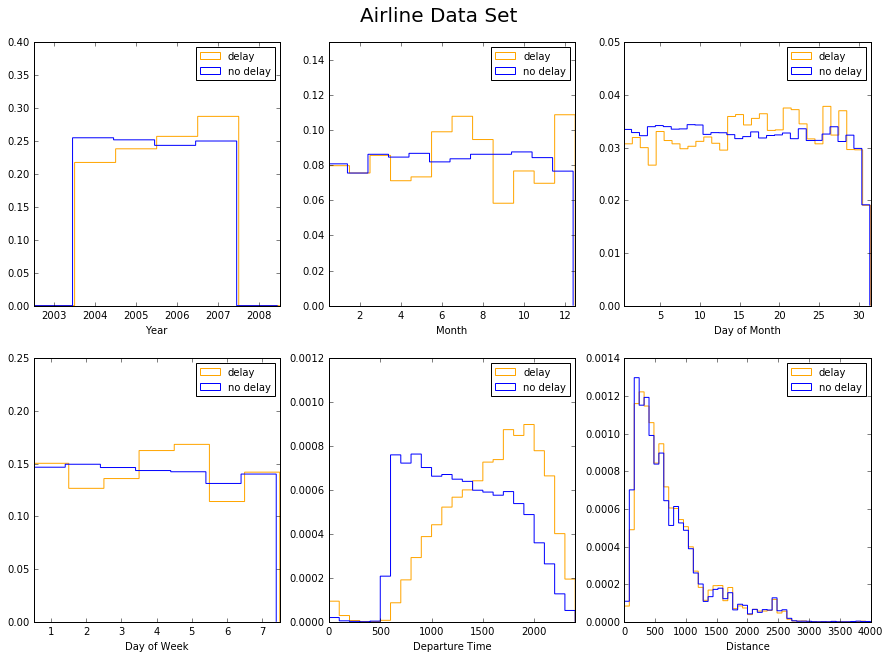

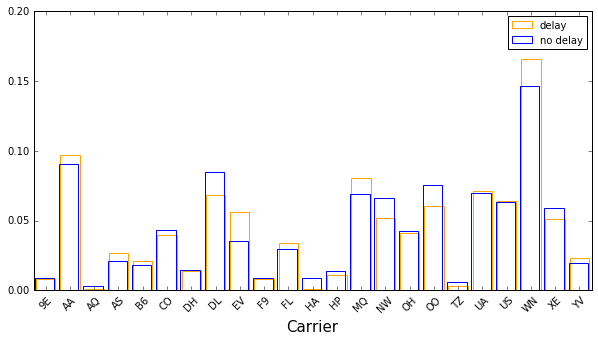

In [2]:
'''
Make plots of feature distributions within the delay and no-delay subsamples, 
so we can get some idea of which features are likely to be most useful.
'''
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots( nrows=2, ncols=3, figsize=(15,10) )
plt.subplots_adjust( wspace=0.20, hspace=0.20, top=0.93 )
plt.suptitle("Airline Data Set", fontsize=20)
Ycol = ["orange"]
Ncol = ["blue"]

axes[0,0].hist(df1_delay.Year,bins=6,range=[2002.5,2008.5],align="mid",
               color=Ycol,histtype="step",label="delay",normed=True)
axes[0,0].hist(df1_nodelay.Year,bins=6,range=[2002.45,2008.45],align="mid",
               color=Ncol,histtype="step",label="no delay",normed=True)
axes[0,0].set_xlabel("Year")
axes[0,0].set_xlim(2002.5,2008.5)
axes[0,0].get_xaxis().get_major_formatter().set_useOffset(False)
axes[0,0].set_ylim(0.0,0.40)
axes[0,0].legend(prop={'size': 10},loc="upper right")

axes[0,1].hist(df1_delay.Month,bins=12,range=[0.5,12.5],align="mid",
               color=Ycol,histtype="step",label="delay",normed=True)
axes[0,1].hist(df1_nodelay.Month,bins=12,range=[0.4,12.4],align="mid",
               color=Ncol,histtype="step",label="no delay",normed=True)
axes[0,1].set_xlabel("Month")
axes[0,1].set_xlim(0.5,12.5)
axes[0,1].set_ylim(0.0,0.15)
axes[0,1].legend(prop={'size': 10},loc="upper right")

axes[0,2].hist(df1_delay.DayofMonth,bins=31,range=[0.5,31.5],align="mid",
               color=Ycol,histtype="step",label="delay",normed=True)
axes[0,2].hist(df1_nodelay.DayofMonth,bins=31,range=[0.4,31.4],align="mid",
               color=Ncol,histtype="step",label="no delay",normed=True)
axes[0,2].set_xlabel("Day of Month")
axes[0,2].set_xlim(0.5,31.5)
axes[0,2].set_ylim(0.0,0.05)
axes[0,2].legend(prop={'size': 10},loc="upper right")

axes[1,0].hist(df1_delay.DayOfWeek,bins=7,range=[0.5,7.5],align="mid",
               color=Ycol,histtype="step",label="delay",normed=True)
axes[1,0].hist(df1_nodelay.DayOfWeek,bins=7,range=[0.4,7.4],align="mid",
               color=Ncol,histtype="step",label="no delay",normed=True)
axes[1,0].set_xlabel("Day of Week")
axes[1,0].set_xlim(0.5,7.5)
axes[1,0].set_ylim(0.0,0.25)
axes[1,0].legend(prop={'size': 10},loc="upper right")

axes[1,1].hist(df1_delay.DepTime,bins=24,range=[0,2400],
               color=Ycol,histtype="step",label="delay",normed=True)
axes[1,1].hist(df1_nodelay.DepTime,bins=24,range=[0,2400],
               color=Ncol,histtype="step",label="no delay",normed=True)
axes[1,1].set_xlabel("Departure Time")
axes[1,1].set_xlim(0.0,2400.0)
axes[1,1].set_ylim(0.0,0.0012)
axes[1,1].legend(prop={'size': 10},loc="upper right")

axes[1,2].hist(df1_delay.Distance,bins=50,range=[0,4000],
               color=Ycol,histtype="step",label="delay",normed=True)
axes[1,2].hist(df1_nodelay.Distance,bins=50,range=[0,4000],
               color=Ncol,histtype="step",label="no delay",normed=True)
axes[1,2].set_xlabel("Distance")
axes[1,2].set_ylim(0.0,0.0014)
axes[1,2].legend(prop={'size': 10},loc="upper right")
plt.show()
#fig.savefig('FlightDelayFeatures1.png', dpi=200, bbox_inches='tight')

fig, axes = plt.subplots( nrows=1, ncols=1, figsize=(10,5) )
bins      = np.arange(numAirlines)
heights   = df1.groupby(["UniqueCarrier","dep_delayed_15min"]).size()
mulind    = pd.MultiIndex.from_product([airlines, [False, True]])
heights   = heights.reindex(mulind).replace(np.nan, 0)
heights1  = [heights[carrier,True] for carrier in airlines]
heights1  = [float(height)/sum(heights1) for height in heights1]
heights2  = [heights[carrier,False] for carrier in airlines]
heights2  = [float(height)/sum(heights2) for height in heights2]
axes.bar(bins,heights1,align="center",edgecolor=Ycol,color=["none"],label="delay")
axes.bar(bins-0.05,heights2,align="center",edgecolor=Ncol,color=["none"],label="no delay")
axes.set_xlabel("Carrier",fontsize=15)
axes.set_xticks(bins)
axes.set_xticklabels(airlines, ha="center", rotation=45.)
axes.set_xlim([-0.5,bins.size-0.5])
axes.set_ylim(0.0,0.20)
axes.legend(prop={'size': 10},loc="upper right")

plt.show()
#fig.savefig('FlightDelayFeatures2.png', dpi=200, bbox_inches='tight')

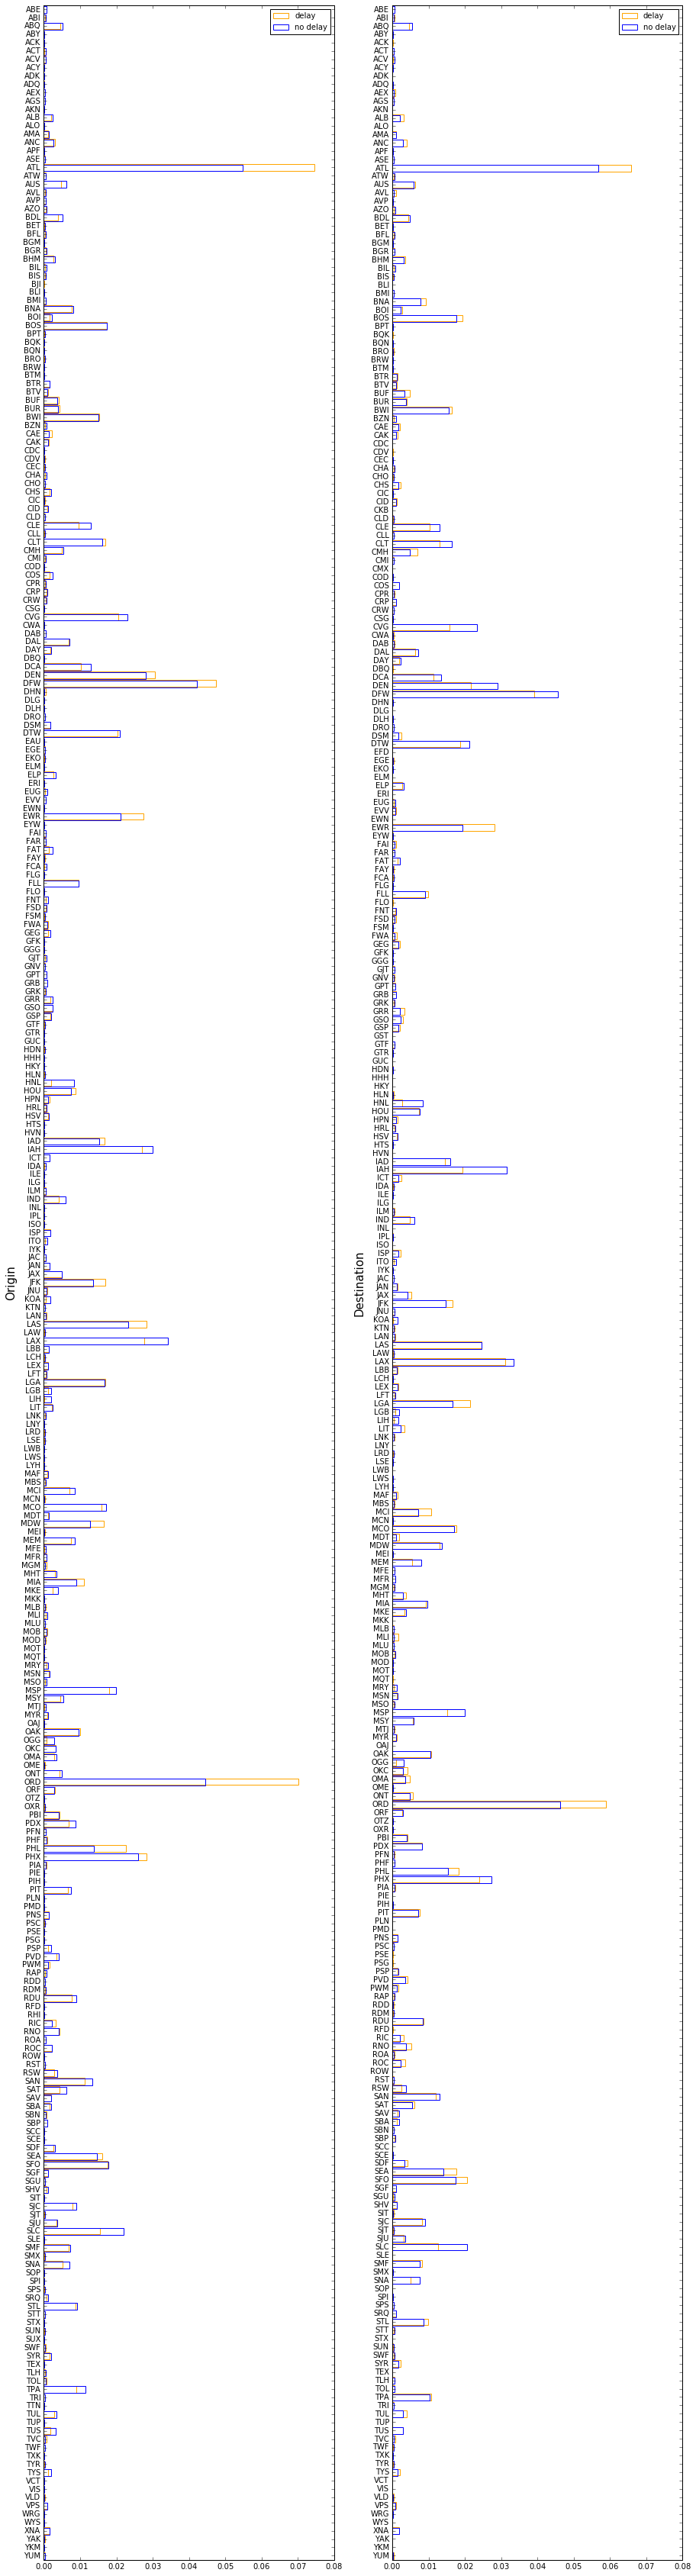

In [3]:
'''
Make plots of the "Origin" and "Destination" feature distributions.  These are
categorical features, with more than 300 categories each, so the plots take a
bit of space...
'''
fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(15,60) )
bins      = np.arange(numOrigins)
heights   = df1.groupby(["Origin","dep_delayed_15min"]).size()
mulind    = pd.MultiIndex.from_product([origins, [False, True]])
heights   = heights.reindex(mulind).replace(np.nan, 0)
heights1  = [heights[origin,True] for origin in origins]
heights1  = [float(height)/sum(heights1) for height in heights1]
heights2  = [heights[origin,False] for origin in origins]
heights2  = [float(height)/sum(heights2) for height in heights2]
axes[0].barh(bins,heights1,align="center",edgecolor=Ycol,color=["none"],label="delay")
axes[0].barh(bins-0.05,heights2,align="center",edgecolor=Ncol,color=["none"],label="no delay")
axes[0].set_ylabel("Origin",fontsize=15)
axes[0].set_yticks(bins)
axes[0].set_yticklabels(origins)
axes[0].set_ylim([-0.5,bins.size-0.5])
axes[0].set_xlim(0.0,0.08)
axes[0].legend(prop={'size': 10},loc="upper right")

bins      = np.arange(numDestinations)
heights   = df1.groupby(["Dest","dep_delayed_15min"]).size()
mulind    = pd.MultiIndex.from_product([destinations, [False, True]])
heights   = heights.reindex(mulind).replace(np.nan, 0)
heights1  = [heights[destination,True] for destination in destinations]
heights1  = [float(height)/sum(heights1) for height in heights1]
heights2  = [heights[destination,False] for destination in destinations]
heights2  = [float(height)/sum(heights2) for height in heights2]
axes[1].barh(bins,heights1,align="center",edgecolor=Ycol,color=["none"],label="delay")
axes[1].barh(bins-0.05,heights2,align="center",edgecolor=Ncol,color=["none"],label="no delay")
axes[1].set_ylabel("Destination",fontsize=15)
axes[1].set_yticks(bins)
axes[1].set_yticklabels(destinations)
axes[1].set_ylim([-0.5,bins.size-0.5])
axes[1].set_xlim(0.0,0.08)
axes[1].legend(prop={'size': 10},loc="upper right")

plt.show()
#fig.savefig('FlightDelayFeatures3.png', dpi=200, bbox_inches='tight')

In [4]:
'''
Compute intrinsic discrepancies.
'''
import numpy as np
from collections import Counter

# Given two histograms x and y (with the same range and binning), the following function
# calculates the intrinsic discrepancy (a symmetrized Kullback-Leibler distance) between them.
def intrinsic_discrepancy(x,y):
    assert len(x)==len(y)
    sumx = np.sum(x)
    sumy = np.sum(y)
    xiny = False
    yinx = False
    for (xval,yval) in zip(x,y):
        if xval==0 and yval>0:
            xiny = True
        if xval>0 and yval==0:
            yinx = True
    if xiny and yinx:         # x and y supports not nested
        return float("inf")
    elif xiny:                # x support nested in y support
        id1  = 0.0
        for (xval,yval) in zip(x,y):
            if xval>0 and yval>0:
                id1 += (float(xval)/sumx) * np.log((float(xval)/sumx)/(float(yval)/sumy))
        return id1
    elif yinx:                # y support nested in x support
        id2  = 0.0
        for (xval,yval) in zip(x,y):
            if xval>0 and yval>0:
                id2 += (float(yval)/sumy) * np.log((float(yval)/sumy)/(float(xval)/sumx))
        return id2
    else:                     # x and y supports identical
        id1  = 0.0
        id2  = 0.0
        for (xval,yval) in zip(x,y):
            if (xval>0) and (yval>0):
                id1 += (float(xval)/sumx) * np.log((float(xval)/sumx)/(float(yval)/sumy))
                id2 += (float(yval)/sumy) * np.log((float(yval)/sumy)/(float(xval)/sumx))
        return min(id1,id2)

int_discr = {}
bin_edges        = np.linspace(2003.5,2007.5,5)
hist1,bin_edges1 = np.histogram(df1_delay.Year,   bins=bin_edges, density=False)
hist2,bin_edges2 = np.histogram(df1_nodelay.Year, bins=bin_edges, density=False)
int_discr["Year"] = intrinsic_discrepancy(hist1,hist2)
bin_edges        = np.linspace(0.5,12.5,13)
hist1,bin_edges1 = np.histogram(df1_delay.Month,   bins=bin_edges, density=False)
hist2,bin_edges2 = np.histogram(df1_nodelay.Month, bins=bin_edges, density=False)
int_discr["Month"] = intrinsic_discrepancy(hist1,hist2)
bin_edges        = np.linspace(0.5,31.5,32)
hist1,bin_edges1 = np.histogram(df1_delay.DayofMonth,   bins=bin_edges, density=False)
hist2,bin_edges2 = np.histogram(df1_nodelay.DayofMonth, bins=bin_edges, density=False)
int_discr["Day of the Month"] = intrinsic_discrepancy(hist1,hist2)
bin_edges        = np.linspace(0.5,7.5,8)
hist1,bin_edges1 = np.histogram(df1_delay.DayOfWeek,   bins=bin_edges, density=False)
hist2,bin_edges2 = np.histogram(df1_nodelay.DayOfWeek, bins=bin_edges, density=False)
int_discr["Day of the Week"] = intrinsic_discrepancy(hist1,hist2)
bin_edges        = np.linspace(0.0,2400.0,24)
hist1,bin_edges1 = np.histogram(df1_delay.DepTime,   bins=bin_edges, density=False)
hist2,bin_edges2 = np.histogram(df1_nodelay.DepTime, bins=bin_edges, density=False)
int_discr["Departure Time"] = intrinsic_discrepancy(hist1,hist2)
bin_edges        = np.linspace(0.0,5000.0,125)
hist1,bin_edges1 = np.histogram(df1_delay.Distance,   bins=bin_edges, density=False)
hist2,bin_edges2 = np.histogram(df1_nodelay.Distance, bins=bin_edges, density=False)
int_discr["Distance"] = intrinsic_discrepancy(hist1,hist2)
hist             = df1.groupby(["Origin","dep_delayed_15min"]).size()
mulind           = pd.MultiIndex.from_product([origins, [False, True]])
hist             = hist.reindex(mulind).replace(np.nan, 0)
hist1            = [hist[origin,True] for origin in origins]
hist2            = [hist[origin,False] for origin in origins]
int_discr["Origin"] = intrinsic_discrepancy(hist1,hist2)
hist             = df1.groupby(["Dest","dep_delayed_15min"]).size()
mulind           = pd.MultiIndex.from_product([destinations, [False, True]])
hist             = hist.reindex(mulind).replace(np.nan, 0)
hist1            = [hist[destination,True] for destination in destinations]
hist2            = [hist[destination,False] for destination in destinations]
int_discr["Destination"] = intrinsic_discrepancy(hist1,hist2)
hist             = df1.groupby(["UniqueCarrier","dep_delayed_15min"]).size()
mulind           = pd.MultiIndex.from_product([airlines, [False, True]])
hist             = hist.reindex(mulind).replace(np.nan, 0)
hist1            = [hist[airline,True] for airline in airlines]
hist2            = [hist[airline,False] for airline in airlines]
int_discr["Airline"] = intrinsic_discrepancy(hist1,hist2)

id_list = Counter(int_discr).most_common()
print('Intrinsic discrepancies between delay and no-delay, in decreasing order: ')
for item in id_list:
    print('   %f  (%s)' % (item[1],item[0]))

Intrinsic discrepancies between delay and no-delay, in decreasing order: 
   inf  (Origin)
   0.240026  (Departure Time)
   0.038243  (Destination)
   0.022571  (Airline)
   0.020530  (Month)
   0.011440  (Distance)
   0.006895  (Day of the Week)
   0.006316  (Year)
   0.005042  (Day of the Month)


In [5]:
'''
Convert categorical variables in dataframe.
'''
df2 = pd.get_dummies(df1,drop_first=False)
print df2.describe(percentiles=[], include="all")

                 Year          Month     DayofMonth     DayOfWeek  \
count   100000.000000  100000.000000  100000.000000  100000.00000   
unique            NaN            NaN            NaN           NaN   
top               NaN            NaN            NaN           NaN   
freq              NaN            NaN            NaN           NaN   
mean      2005.512710       6.541110      15.723870       3.94819   
std          1.122306       3.415609       8.801126       1.99326   
min       2004.000000       1.000000       1.000000       1.00000   
50%       2006.000000       7.000000      16.000000       4.00000   
max       2007.000000      12.000000      31.000000       7.00000   

              DepTime       Distance dep_delayed_15min  UniqueCarrier_9E  \
count   100000.000000  100000.000000            100000     100000.000000   
unique            NaN            NaN                 2               NaN   
top               NaN            NaN             False               NaN   
freq 

In [6]:
'''
Recompute intrinsic discrepancies, this time using the dummy variables in data frame df2.
''' 
df2_delay   = df2[df2.dep_delayed_15min==True]
df2_nodelay = df2[df2.dep_delayed_15min==False]

int_discr = {}
bin_edges        = np.linspace(2003.5,2007.5,5)
hist1,bin_edges1 = np.histogram(df2_delay.Year,   bins=bin_edges, density=False)
hist2,bin_edges2 = np.histogram(df2_nodelay.Year, bins=bin_edges, density=False)
int_discr["Year"] = intrinsic_discrepancy(hist1,hist2)
bin_edges        = np.linspace(0.5,12.5,13)
hist1,bin_edges1 = np.histogram(df2_delay.Month,   bins=bin_edges, density=False)
hist2,bin_edges2 = np.histogram(df2_nodelay.Month, bins=bin_edges, density=False)
int_discr["Month"] = intrinsic_discrepancy(hist1,hist2)
bin_edges        = np.linspace(0.5,31.5,32)
hist1,bin_edges1 = np.histogram(df2_delay.DayofMonth,   bins=bin_edges, density=False)
hist2,bin_edges2 = np.histogram(df2_nodelay.DayofMonth, bins=bin_edges, density=False)
int_discr["Day of the Month"] = intrinsic_discrepancy(hist1,hist2)
bin_edges        = np.linspace(0.5,7.5,8)
hist1,bin_edges1 = np.histogram(df2_delay.DayOfWeek,   bins=bin_edges, density=False)
hist2,bin_edges2 = np.histogram(df2_nodelay.DayOfWeek, bins=bin_edges, density=False)
int_discr["Day of the Week"] = intrinsic_discrepancy(hist1,hist2)
bin_edges        = np.linspace(0.0,2400.0,24)
hist1,bin_edges1 = np.histogram(df2_delay.DepTime,   bins=bin_edges, density=False)
hist2,bin_edges2 = np.histogram(df2_nodelay.DepTime, bins=bin_edges, density=False)
int_discr["Departure Time"] = intrinsic_discrepancy(hist1,hist2)
bin_edges        = np.linspace(0.0,5000.0,125)
hist1,bin_edges1 = np.histogram(df2_delay.Distance,   bins=bin_edges, density=False)
hist2,bin_edges2 = np.histogram(df2_nodelay.Distance, bins=bin_edges, density=False)
int_discr["Distance"] = intrinsic_discrepancy(hist1,hist2)

# Now do the dummy variables, starting at column 7 to skip the 6 columns we already did, 
# plus the response column "dep_delayed_15min".
bin_edges   = np.linspace(-0.5, 1.5, 3)
for cname in list(df2.columns.values)[7:]:
    hist1,bin_edges1 = np.histogram(df2_delay[cname],   bins=bin_edges, density=False)
    hist2,bin_edges2 = np.histogram(df2_nodelay[cname], bins=bin_edges, density=False)
    int_discr[cname] = intrinsic_discrepancy(hist1, hist2)
    
id_list  = Counter(int_discr).most_common()
ndisplay = 20
print('Top %i intrinsic discrepancies between delay and no-delay, in decreasing order: ' %ndisplay)
for item in id_list[:ndisplay]:
    print('   %f  (%s)' % (item[1],item[0]))

Top 20 intrinsic discrepancies between delay and no-delay, in decreasing order: 
   0.240026  (Departure Time)
   0.020530  (Month)
   0.011440  (Distance)
   0.006895  (Day of the Week)
   0.006316  (Year)
   0.005753  (Origin_ORD)
   0.005594  (UniqueCarrier_HA)
   0.005042  (Day of the Month)
   0.004637  (UniqueCarrier_EV)
   0.003561  (Origin_HNL)
   0.003113  (Origin_ATL)
   0.002816  (Dest_IAH)
   0.002537  (Dest_HNL)
   0.002002  (Origin_PHL)
   0.001872  (UniqueCarrier_DL)
   0.001765  (UniqueCarrier_NW)
   0.001764  (Dest_SLC)
   0.001712  (UniqueCarrier_OO)
   0.001565  (Dest_EWR)
   0.001527  (Origin_LIH)


In [59]:
'''
Prepare training and test data for scikit-learn's random forest classifier.

There is the possibility to separately adjust the prevalences in the training and testing data sets,
provided the desired prevalences are larger than the existing one.
'''
import numpy as np
from sklearn.cross_validation import train_test_split

test_fraction     = 0.30  # Fraction of total data set used for testing.
adjust_prevalence = False # Set to True to modify the prevalence in the training and/or testing data sets.
test_prevalence   = 0.60  # Desired prevalence in testing data set, only used if adjust_prevalence = True
train_prevalence  = 0.45  # Desired prevalence in training data set, only used if adjust_prevalence = True

np.random.seed(1)         # Random numbers are used by routine selectSubarray

# Routine to randomly mask off a fraction frac of elements equal to elval in array arr.
def selectSubarray( arr, elval, frac ):
    mask = np.ones(len(arr), dtype=bool)
    for ind,val in enumerate(arr):
        if val == elval:
            if np.random.uniform() <= frac:
                mask[ind] = False
    return mask

# Convert pandas dataframe to its numpy representation, separating out features from target variable.
features = df2.columns.values.tolist()
features.remove("dep_delayed_15min")
X0 = df2.as_matrix(columns=features)
Y0 = np.array([int(ybool) for ybool in df2["dep_delayed_15min"].tolist()])

# Make sure desired prevalences are larger than initial prevalence.
prev = float(len([y for y in Y0 if y==1]))/len(Y0)
print("Initial data set prevalence: %f" %prev)
assert test_prevalence >= prev,  "Desired test data set prevalence below current value"
assert train_prevalence >= prev, "Desired train data set prevalence below current value"

# If adjusting the prevalence differently in training and test data sets, the fraction of test data 
# needs to be adjusted to compensate.
if adjust_prevalence:
    test_f  = 1.0/(1.0+(train_prevalence/test_prevalence)*(1.0/test_fraction-1.0))
    test_d  = (1.0/prev - 1.0/test_prevalence)/(1.0/prev - 1.0)
    train_d = (1.0/prev - 1.0/train_prevalence)/(1.0/prev - 1.0)
else:
    test_f  = test_fraction

# Create training and test sets, with desired proportions.
X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, Y0, test_size=test_f, random_state=0)

# Adjust prevalences by removing data points belonging to class 0.
if adjust_prevalence:
    mask    = selectSubarray( y_train0, 0, train_d)
    X_train = X_train0[mask]
    y_train = y_train0[mask]
    mask    = selectSubarray( y_test0, 0, test_d)
    X_test  = X_test0[mask]
    y_test  = y_test0[mask]
    X       = np.append( X_train, X_test, axis=0)
    Y       = np.append( y_train, y_test, axis=0)
else:
    X_train = X_train0[:]
    y_train = y_train0[:]
    X_test  = X_test0[:]
    y_test  = y_test0[:]
    X       = X0[:]
    Y       = Y0[:]

print("Training set size: %i, test set size: %i, total: %i, test fraction: %f" \
      %(len(y_train),len(y_test),len(Y),float(len(y_test))/len(Y)))
train_prevalence = float(len([y for y in y_train if y==1]))/len(y_train)
test_prevalence  = float(len([y for y in y_test if y==1]))/len(y_test)
print("Prevalence in training set: %f, in test set: %f" %(train_prevalence,test_prevalence))

Initial data set prevalence: 0.192740
Training set size: 70000, test set size: 30000, total: 100000, test fraction: 0.300000
Prevalence in training set: 0.192557, in test set: 0.193167


In [63]:
'''
Fit a random forest classifier to the training data.
'''
from sklearn.ensemble import RandomForestClassifier

rf2 = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_leaf=2, 
                             criterion="gini", min_samples_split=2, min_weight_fraction_leaf=0.0, 
                             max_features="auto", max_leaf_nodes=None, bootstrap=True,
                             oob_score=True, verbose=0, warm_start=False, random_state=0, 
                             n_jobs=-1, class_weight="balanced_subsample")
%time rf2.fit(X_train, y_train)

CPU times: user 2min 47s, sys: 2.46 s, total: 2min 50s
Wall time: 50.6 s


RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [13]:
'''
Do a grid search to find optimal hyper-parameters of the random forest classifier.
We use the area under the ROC curve to score parameter choices.

(This cell can be omitted if the previous one was run.)
'''
import numpy as np
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Specify the parameter grid to be searched
parameter_grid = [{'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20], 
                   'min_samples_leaf': [1, 2, 3, 4, 5, 10, 20]}]

# Start the grid search
clf = GridSearchCV(RandomForestClassifier(criterion="gini", min_samples_split=2, min_weight_fraction_leaf=0.0,
                                          max_features="auto", max_leaf_nodes=None, bootstrap=True,
                                          oob_score=True, verbose=0, warm_start=False, random_state=0,
                                          n_jobs=-1, class_weight="balanced_subsample"), 
                   parameter_grid, refit=True, cv=3, scoring='roc_auc')
%time clf.fit(X_train, y_train)

# Print out the results
print("Best parameter values found on development set:")
print(" ")
print(clf.best_params_)
print(" ")
print("Grid scores on development set:")
print(" ")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" %(mean_score, scores.std()*2, params))

# Retrieve best random forest model from grid search
rf2 = clf.best_estimator_
print("\nBest estimator:\n%s" %rf2)

CPU times: user 1h 59min 1s, sys: 3min 47s, total: 2h 2min 49s
Wall time: 40min 48s
Best parameter values found on development set:
 
{'n_estimators': 200, 'max_depth': 20, 'min_samples_leaf': 2}
 
Grid scores on development set:
 
0.683 (+/-0.009) for {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 1}
0.689 (+/-0.007) for {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 1}
0.691 (+/-0.008) for {'n_estimators': 200, 'max_depth': 5, 'min_samples_leaf': 1}
0.683 (+/-0.013) for {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 2}
0.689 (+/-0.007) for {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 2}
0.690 (+/-0.007) for {'n_estimators': 200, 'max_depth': 5, 'min_samples_leaf': 2}
0.683 (+/-0.012) for {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 3}
0.689 (+/-0.008) for {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 3}
0.691 (+/-0.008) for {'n_estimators': 200, 'max_depth': 5, 'min_samples_leaf': 3}
0.682 (+/-0.012) for {'n_estimato

In [64]:
'''
Compute confusion matrix and print classification report.
'''
from sklearn.metrics import classification_report, confusion_matrix

print("Estimator currently in use:\n\n%s\n" %rf2)

# score the model
Ntest    = len(y_test)
Ntestpos = len([val for val in y_test if val])
NullAcc  = float(Ntest-Ntestpos)/Ntest
print("Mean accuracy on Training set: %s" %rf2.score(X_train, y_train))
print("Mean accuracy on Test set:     %s" %rf2.score(X_test, y_test))
print("Null accuracy on Test set:     %s" %NullAcc)
print(" ")
y_true, y_pred = y_test, rf2.predict(X_test)
cm             = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\ntn=%6d  fp=%6d\nfn=%6d  tp=%6d" %(cm[0][0],cm[0][1],cm[1][0],cm[1][1]))
print("\nDetailed classification report: \n%s" %classification_report(y_true, y_pred))

Estimator currently in use:

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

Mean accuracy on Training set: 0.673242857143
Mean accuracy on Test set:     0.645733333333
Null accuracy on Test set:     0.806833333333
 
Confusion matrix:
tn= 15458  fp=  8747
fn=  1881  tp=  3914

Detailed classification report: 
             precision    recall  f1-score   support

          0       0.89      0.64      0.74     24205
          1       0.31      0.68      0.42      5795

avg / total       0.78      0.65      0.68     30000



Number of test values = 30000
Number of test values equal to True = 5795


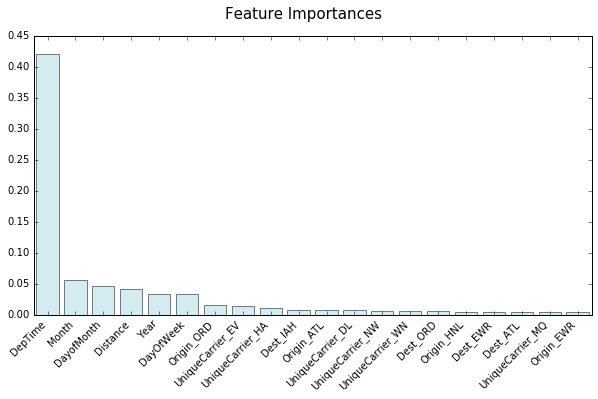

Number of thresholds = 29872
Delays in training set: 13479, no-delays: 56521
Delays in test set: 5795, no-delays: 24205
Intrinsic discrepancy in training set: 0.53419185456, in test set: 0.311319146377


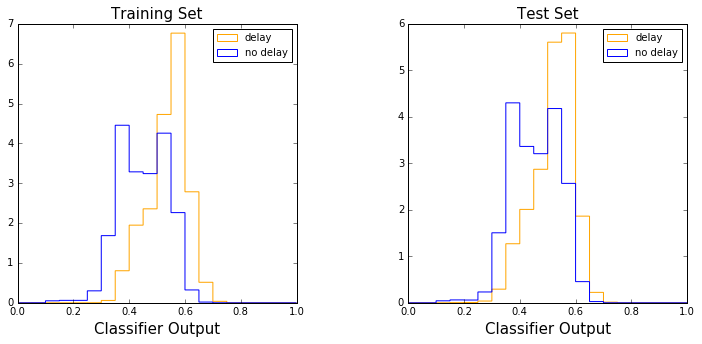

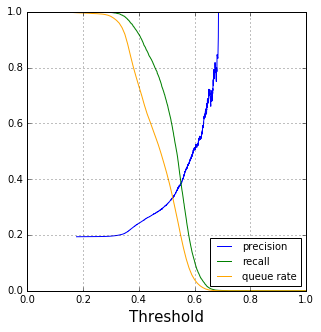

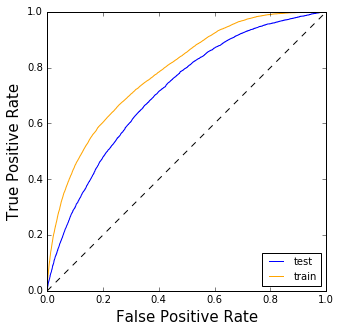

Area under test ROC =  0.716895014703
Area under train ROC = 0.786378939332


In [65]:
'''
Make plots to summarize the properties of our model.
'''
from sklearn import metrics
import numpy as np

print('Number of test values = %i' %len(y_test))
print('Number of test values equal to True = %i' %(len([val for val in y_test if val])))

# Compute and plot feature importances
importances = rf2.feature_importances_
indices     = np.argsort(importances)[::-1]
n_features  = min(20,indices.size)
bins        = np.arange(n_features)
x_labels    = np.array(features)[indices][:n_features]
fig, axes   = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
plt.suptitle("Feature Importances", fontsize=15)
axes.bar(bins, importances[indices][:n_features], align="center", color="lightblue", alpha=0.5)
axes.set_xticks(bins)
axes.set_xticklabels(x_labels, ha="right", rotation=45.)
axes.set_xlim([-0.5,bins.size-0.5])
plt.show()
#fig.savefig('FeatureImportances.png', dpi=200, bbox_inches='tight')

# Compute precision, recall, and queue rate as a function of threshold
y_test_pred    = [p2 for [p1,p2] in rf2.predict_proba(X_test)]
y_train_pred   = [p2 for [p1,p2] in rf2.predict_proba(X_train)]
td0_precision, td0_recall, td0_thresholds = metrics.precision_recall_curve(y_test, y_test_pred)
td0_thresholds = np.append(td0_thresholds, 1)
n_thresholds   = td0_thresholds.size
print('Number of thresholds = %i' %n_thresholds)
n_max          = 100
qr_thresholds  = np.linspace(0.0, 1.0, n_max+1)
td0_queue_rate = []  
for threshold in qr_thresholds:  
    td0_queue_rate.append((y_test_pred >= threshold).mean())

# Histogram random forest output probabilities
y_train_pred_1 = [pred for (pred,truth) in zip(y_train_pred,y_train) if truth==1]
y_train_pred_0 = [pred for (pred,truth) in zip(y_train_pred,y_train) if truth==0]
y_test_pred_1  = [pred for (pred,truth) in zip(y_test_pred,y_test) if truth==1]
y_test_pred_0  = [pred for (pred,truth) in zip(y_test_pred,y_test) if truth==0]
print("Delays in training set: %i, no-delays: %i" %(len(y_train_pred_1),len(y_train_pred_0)))
print("Delays in test set: %i, no-delays: %i" %(len(y_test_pred_1),len(y_test_pred_0)))
bin_edges        = np.linspace(0.0,1.0,11)
hist1,bin_edges1 = np.histogram(y_train_pred_1, bins=bin_edges, density=False)
hist2,bin_edges2 = np.histogram(y_train_pred_0, bins=bin_edges, density=False)
indis_train      = intrinsic_discrepancy(hist1, hist2)
hist1,bin_edges1 = np.histogram(y_test_pred_1, bins=bin_edges, density=False)
hist2,bin_edges2 = np.histogram(y_test_pred_0, bins=bin_edges, density=False)
indis_test       = intrinsic_discrepancy(hist1, hist2)
print("Intrinsic discrepancy in training set: %s, in test set: %s" %(indis_train,indis_test))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plt.subplots_adjust(wspace=0.40)
axes[0].hist(y_train_pred_1, bins=20, range=[0.0,1.0], color=Ycol, histtype="step", label="delay", normed=True)
axes[0].hist(y_train_pred_0, bins=20, range=[0.0,1.0], color=Ncol, histtype="step", label="no delay", normed=True)
axes[0].set_xlabel("Classifier Output", fontsize=15)
axes[0].legend(prop={'size': 10}, loc="upper right")
axes[0].set_title("Training Set", fontsize=15)
axes[1].hist(y_test_pred_1, bins=20, range=[0.0,1.0], color=Ycol, histtype="step", label="delay", normed=True)
axes[1].hist(y_test_pred_0, bins=20, range=[0.0,1.0], color=Ncol, histtype="step", label="no delay", normed=True)
axes[1].set_xlabel("Classifier Output", fontsize=15)
axes[1].legend(prop={'size': 10}, loc="upper right")
axes[1].set_title("Test Set", fontsize=15)
plt.show()
#fig.savefig('RF_probabilities.png', dpi=200, bbox_inches='tight')
    
# Plot precision, recall, and queue rate
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
axis.plot(td0_thresholds, td0_precision, color="blue", label="precision")
axis.plot(td0_thresholds, td0_recall, color="green", label="recall")
axis.plot(qr_thresholds, td0_queue_rate, color="orange", label="queue rate")
axis.set_xlabel("Threshold", fontsize=15)
axis.set_xlim(0.0, 1.0)
axis.set_ylim(0.0, 1.0)
axis.grid(which="major", axis="both")
axis.legend(prop={'size': 10}, loc="lower right")
plt.show()
#fig.savefig("PRQ.png", dpi=200, bbox_inches="tight")

# Compute and plot ROC
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
fpr_test, tpr_test, thresholds   = metrics.roc_curve(y_test, y_test_pred)
auroc_test                       = metrics.auc(fpr_test,tpr_test)
fpr_train, tpr_train, thresholds = metrics.roc_curve(y_train, y_train_pred)
auroc_train                      = metrics.auc(fpr_train,tpr_train)
axis.plot(fpr_test, tpr_test, color="blue", label="test")
axis.plot(fpr_train, tpr_train, color="orange", label="train")
axis.plot([0.0,1.0], [0.0,1.0], 'k--')
axis.set_xlabel("False Positive Rate", fontsize=15)
axis.set_ylabel("True Positive Rate", fontsize=15)
axis.set_xlim(0.0, 1.0)
axis.set_ylim(0.0, 1.0)
axis.legend(prop={'size': 10}, loc="lower right")
plt.show()
#fig.savefig('ROC.png', dpi=200, bbox_inches='tight')

print('Area under test ROC =  %s' %auroc_test)
print('Area under train ROC = %s' %auroc_train)

In [33]:
'''
To investigate variability, perform 50 splits of the data set intro training+testing subsets,
run the classifier on them, and get the precision, recall, and queue rate versus threshold curves.
'''
rf3 = RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, verbose=0, warm_start=False)

n_trials = 50  
test_fraction = 0.30

plot_data = []

for trial in range(n_trials):
    print("Now starting trial %i" %trial)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_fraction)
    rf3.fit(X_train, y_train)
    y_test_pred = rf3.predict_proba(X_test)[:,1]
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred)
    thresholds = np.append(thresholds, 1)
    queue_rate = []
    for threshold in thresholds:
        queue_rate.append((y_test_pred >= threshold).mean())

    plot_data.append({
            'thresholds': thresholds
        ,   'precision': precision
        ,   'recall': recall
        ,   'queue_rate': queue_rate
    })

Now starting trial 0
Now starting trial 1
Now starting trial 2
Now starting trial 3
Now starting trial 4
Now starting trial 5
Now starting trial 6
Now starting trial 7
Now starting trial 8
Now starting trial 9
Now starting trial 10
Now starting trial 11
Now starting trial 12
Now starting trial 13
Now starting trial 14
Now starting trial 15
Now starting trial 16
Now starting trial 17
Now starting trial 18
Now starting trial 19
Now starting trial 20
Now starting trial 21
Now starting trial 22
Now starting trial 23
Now starting trial 24
Now starting trial 25
Now starting trial 26
Now starting trial 27
Now starting trial 28
Now starting trial 29
Now starting trial 30
Now starting trial 31
Now starting trial 32
Now starting trial 33
Now starting trial 34
Now starting trial 35
Now starting trial 36
Now starting trial 37
Now starting trial 38
Now starting trial 39
Now starting trial 40
Now starting trial 41
Now starting trial 42
Now starting trial 43
Now starting trial 44
Now starting trial 4

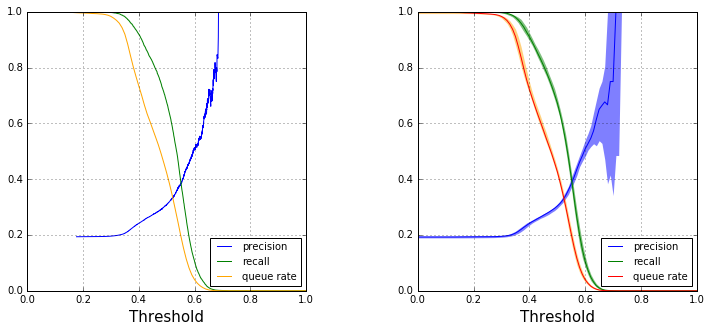

In [71]:
'''
Plot the precision, recall, and queue rate versus threshold curves with 90% confidence bands.
'''
import bisect  
from scipy.stats import mstats

uniform_thresholds = np.linspace(0, 1, 101)

uniform_precision_plots = []  
uniform_recall_plots= []  
uniform_queue_rate_plots= []

for p in plot_data:  
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])

    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

quantiles = [0.05, 0.50, 0.95]
lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0)
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0)
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plt.subplots_adjust(wspace=0.40)

# Plot precision, recall, and queue rate from testing set
axes[0].plot(td0_thresholds, td0_precision, color="blue", label="precision")
axes[0].plot(td0_thresholds, td0_recall, color="green", label="recall")
axes[0].plot(qr_thresholds, td0_queue_rate, color="orange", label="queue rate")
axes[0].set_xlabel("Threshold", fontsize=15)
axes[0].set_xlim(0.0, 1.0)
axes[0].set_ylim(0.0, 1.0)
axes[0].grid(which="major", axis="both")
axes[0].legend(prop={'size': 10}, loc="lower right")

# Plots median and confidence belts from resplit data set
axes[1].plot(uniform_thresholds, median_precision, label="precision")
axes[1].plot(uniform_thresholds, median_recall, label="recall")
axes[1].plot(uniform_thresholds, median_queue_rate, label="queue rate")
axes[1].fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color="blue")
axes[1].fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color="green")
axes[1].fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color="orange")
axes[1].set_xlabel("Threshold", fontsize=15)
axes[1].set_xlim(0.0, 1.0)
axes[1].set_ylim(0.0, 1.0)
axes[1].grid(which="major", axis="both")
axes[1].legend(prop={'size': 10}, loc="lower right")
plt.show()
#fig.savefig('PRQ2_belts.png', dpi=200, bbox_inches='tight')